# Overall Strategy
- Use newsAPI to find companies that are trending (week 1)
- Use kaggle dataset to find patterns in stock trades (week 2)
- (week 3)
- Combine all strategies to make estimates on stocks that should be invested in.
    - Strategies that proved more sucessful in the end will have more weight

*notes: using NASDAQ*

### Week 1

- NewsApi will search for articles that include the stock ticker
- Based on article count we know which companies are being talked about more
    - Hopefully in a good way (Will hopefully adjust for this later)
- Using top 50 Companies based on Market Cap
- Output includes company name + Article count
- Based on this we can invest in the companies being talked about the most.

In [75]:
!pip install spacy
!pip install newsapi-python
!pip install fsspec

  Using cached pathy-0.6.1-py3-none-any.whl (42 kB)
  Using cached typer-0.4.0-py3-none-any.whl (27 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached catalogue-2.0.6-py3-none-any.whl (17 kB)
  Using cached spacy_loggers-1.0.1-py3-none-any.whl (7.0 kB)
  Using cached spacy_legacy-3.0.8-py2.py3-none-any.whl (14 kB)
  Using cached wasabi-0.8.2-py3-none-any.whl (23 kB)
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)
  Using cached newsapi_python-0.2.6-py2.py3-none-any.whl (7.9 kB)


In [82]:
#import libraries
from newsapi import NewsApiClient
import pandas as pd
import json
import csv

# top 50 traded Companies by Market CAP
# Limited to 50 since API only allows 100 request perday with free account
companies = ['Apple','Microsoft','Google','Alphabet','Amazon','Tesla','Facebook','Nvidia','Taiwan Semiconductor','JP Morgan',
             'Visa','Home Depot','Johnson & Johnson','United Health','ADI','Bank of America','Walmart','Alibaba','GameStop','Procter & Gamble',
             'Mastercard','Adobe','Netflix','NTES','CRM','Pfizer','Disney','Nike','Exxon','Novo',
             'Oracle','Toyota','Thermo','Eli Lilly','Comcast','Coca-Cola','AMC','Paypal','Rivian','Costco',
             'Cisco','PEPSI','Abbott Laboratories','Danaher','Chevron','Verizon','Shopify','Merck & Company','Qualcomm','AbbVie']

#Used for testing (ignore)
test_companies = ['AAPL','PEPSI','TSLA']

#Init
newsapi = NewsApiClient(api_key='3eaeabeef28c459d96502d7c196ac421')

In [83]:
article_results = []

for x in range(50):
    #used to filter searches that mention the stock market in realtion to company
    q = companies[x]+' NASDAQ'
    data = newsapi.get_everything(q=q,from_param='2021-11-15',
                                      to='2021-11-24', language='en', page_size=0)
    article_results.append(data['totalResults'])

list_of_results = list(zip(companies, article_results))
df = pd.DataFrame(list_of_results, columns = ['company','results'])
df.sort_values('results')
print(df)

                 company  results
0                  Apple      187
1              Microsoft      145
2                 Google      161
3               Alphabet       75
4                 Amazon      210
5                  Tesla      256
6               Facebook      484
7                 Nvidia      173
8   Taiwan Semiconductor       15
9              JP Morgan       19
10                  Visa       61
11            Home Depot      105
12     Johnson & Johnson       78
13         United Health      287
14                   ADI       13
15       Bank of America      131
16               Walmart      155
17               Alibaba       74
18              GameStop       19
19      Procter & Gamble       11
20            Mastercard       45
21                 Adobe       24
22               Netflix       55
23                  NTES       13
24                   CRM       30
25                Pfizer       72
26                Disney       33
27                  Nike       41
28            

In [84]:
df.to_excel("output.xlsx")

# Results from Day 1
 I ajdusted the names to be the full name. Just using the stock ticker name produced very little results for some. And some tickers produced un-realted results

# List
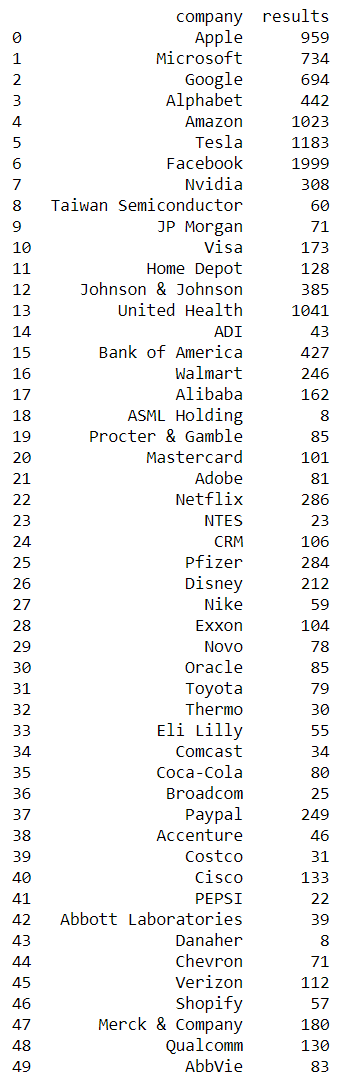

# Data
![avg.png](attachment:avg.png)

### Stock Buys
- Facebook had the most hits with 1999 
    - Bought 30k shares 11/18/21 (Pre-market)
- Tesla had 2 most with 1183
    - Bought 20k shares 11/18/21 (Pre-Market)
- United Health was 3rd with 1041
    - Bought 10k shares 11/18/21 (Pre-Market)

## Results after day 1
- My total gain is 2.58

# Week 2
## Data Prediciton
- making preditions based on real data
- making prediction on closing price

### Strategy
- Check the predicted Next day price for Companies I am invested in
- Check companies that look of interest

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import sklearn

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [102]:
#Load data
company = 'WMT'
start = dt.datetime(2018,1,1)
end = dt.datetime(2021,1,1)

data = web.DataReader(company, 'yahoo', start, end) #Load from yahoo finance database

In [103]:
#prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60  #how many days we are looking back to base new predicted price on

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [104]:
#Build Neural Network Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
22/22 [==============================] - 4s 33ms/step - loss: 0.0364
Epoch 2/25
22/22 [==============================] - 1s 34ms/step - loss: 0.0055
Epoch 3/25
22/22 [==============================] - 1s 39ms/step - loss: 0.0049
Epoch 4/25
22/22 [==============================] - 1s 37ms/step - loss: 0.0051
Epoch 5/25
22/22 [==============================] - 1s 35ms/step - loss: 0.0050
Epoch 6/25
22/22 [==============================] - 1s 35ms/step - loss: 0.0049
Epoch 7/25
22/22 [==============================] - 1s 36ms/step - loss: 0.0043
Epoch 8/25
22/22 [==============================] - 1s 37ms/step - loss: 0.0042
Epoch 9/25
22/22 [==============================] - 1s 36ms/step - loss: 0.0041
Epoch 10/25
22/22 [==============================] - 1s 34ms/step - loss: 0.0044
Epoch 11/25
22/22 [==============================] - 1s 34ms/step - loss: 0.0038
Epoch 12/25
22/22 [==============================] - 1s 35ms/step - loss: 0.0048
Epoch 13/25
22/22 [==================

In [105]:
#Load Test Data
test_start=dt.datetime(2020, 1, 1)
test_end=dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices=test_data['Close'].values

total_dataset=pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [106]:
# Make Predictions on Test Data
x_test=[]

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

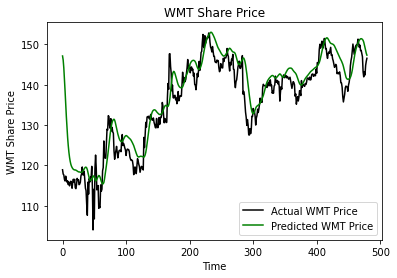

In [107]:
# Plot the test predictions
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [109]:
#Predict Next Day

real_data = [model_inputs[len(model_inputs)+2-prediction_days:len(model_inputs+1), 0]] #change model_inputs +2 --> 1 to fix bug
real_data = np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction=model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[147.09341]]


# *Results* (11/24/21)
## Current Portfolio
 - FB Prediction: [[325.46506]] Current: 341.06  --> Sell
 - TSLA Prediction: [[1004.28436]] Current: 1116.00 --> Sell
 - UNH Prediction: Prediction: [[442.34647]] Current: 450.16 --> Sell
 
## New Options Based on NewsApi Stats
- Amazon Prediction: [[3556.087]] current: 3580.41 --> no
- Rivian N/A not enough data for model --> Buy 5k based on News API (test)
- Walmart Prediction: [[147.09341] current: 146.54 --> Buy 20k worth of shares
- Nvidia Prediction: [[333.25783]] current: 326.74 --> Buy 90K worth of shares
- Facebook --> buy 10k back
    - had unusally high results from news API